# Noise PSDs by USRP Power
## Import the libraries

In [1]:
import sys, os, glob, h5py
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import TimestreamHelperFunctions as Thf

## Load some parameters

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
# line_atten_dB_NEXUS = 56.5
line_atten_dB_NEXUS = 60

## Define the noise runs in power order

In [3]:
## 11/8 Al Runs - Shield Closed, No Laser, No sources (NR 15)
series_list = np.array([
    "20221108_093729",
    "20221108_093600",
    "20221108_093431",
    "20221108_093301",
    "20221108_093132",
    "20221108_093003",
    "20221108_092834",
    "20221108_092702",
    "20221108_092534",
    "20221108_092406",
    "20221108_092238",
    "20221108_092104",
])

P_min = -70 ; P_max = -15 ; P_step = 5
powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

In [4]:
# ## 2/12/23 Al Runs - Shield Closed, No Laser, No sources (NR 17)
# series_list = np.array([
#     "20230212_224409",
#     "20230212_224240",
#     "20230212_224111",
#     "20230212_223942",
#     "20230212_223813",
#     "20230212_223644",
#     "20230212_223515",
#     "20230212_223346",
#     "20230212_223217",
#     "20230212_223049",
#     "20230212_222921",
#     "20230212_222746",
# ])

# P_min = -70 ; P_max = -15 ; P_step = 5
# powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

In [5]:
# ## 2/22/23 Nb7 Runs - Shield Closed, No Laser, No sources (NR 17)
# series_list = np.array([
#     "20230222_155910", 
#     "20230222_155740", 
#     "20230222_155610", 
#     "20230222_155440", 
#     "20230222_155310", 
#     "20230222_155140", 
#     "20230222_155010", 
#     "20230222_154840", 
#     "20230222_154711", 
#     "20230222_154542", 
#     "20230222_154413", 
#     "20230222_154237"
# ])

# P_min = -70 ; P_max = -15 ; P_step = 5
# powers_list = np.arange(start=P_max, stop=P_min-P_step, step=-P_step)

In [6]:
# series_list = series_list[2:-3][::-1]
# powers_list = powers_list[2:-3][::-1]

# ## This is the set to use to compare with Caltech
# series_list = series_list[1:-5][::-1]
# powers_list = powers_list[1:-5][::-1]

series_list = series_list[::-1]
powers_list = powers_list[::-1]

In [7]:
pwr_on_chip = powers_list - line_atten_dB_NEXUS
series_list = series_list[pwr_on_chip != -110]
powers_list = powers_list[pwr_on_chip != -110]
pwr_on_chip = pwr_on_chip[pwr_on_chip != -110]

In [8]:
for i in np.arange(len(series_list)):
    print(series_list[i], ":", powers_list[i],"/",pwr_on_chip[i], "dBm")

20221108_092104 : -70 / -130 dBm
20221108_092238 : -65 / -125 dBm
20221108_092406 : -60 / -120 dBm
20221108_092534 : -55 / -115 dBm
20221108_092834 : -45 / -105 dBm
20221108_093003 : -40 / -100 dBm
20221108_093132 : -35 / -95 dBm
20221108_093301 : -30 / -90 dBm
20221108_093431 : -25 / -85 dBm
20221108_093600 : -20 / -80 dBm
20221108_093729 : -15 / -75 dBm


## Load the metadata

In [9]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series_list[0], verbose=True)
metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
print(avg_frqs, avg_S21s)

Line Delay file:  USRP_Delay_20221108_092104.h5
VNA scan file:    USRP_VNA_20221108_092104.h5
Noise ts files:   ['USRP_Noise_20221108_092104_delta0.h5']
Laser ts files:   []
Summary file:	 noise_averages_20221108_092104.h5
[4242.048018 4242.048953 4242.049889] [0.00026753+0.00013661j 0.00026267+0.0001427j  0.00025541+0.0001617j ]


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


## Show an example timestream and PSD

In [10]:
powers, PSDs, res, timestreams = Thf.CleanPSDs(tone_files[0], vna_file, f_transient=0.075,
                                               charFs = avg_frqs,
                                               charZs = avg_S21s,
                                               MBresults = None, #MB_fit_vals,
                                               show_plots = False,
                                               verbose = False)
print(np.array(res.keys()))

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_092104/USRP_Noise_20221108_092104_delta0.h5 because override=True!
found 11 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_092104/USRP_Noise_20221108_092104_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
dict_keys(['fr', 'Qr', 'Qc', 'a', 'phi'])


In [11]:
print(",".join(res.keys()))
print(str(res.values()).split("[")[1].split("]")[0].replace(' ',''))

fr,Qr,Qc,a,phi
4242.048953412223,226724.0812037177,693180.647954466,(0.0003944707229688015+0.0002128741985092224j),-0.0746794671143911


## Calculate and plot PSDs for every power

In [12]:
%matplotlib notebook

In [13]:
f_interst = [1.0e3]

<IPython.core.display.Javascript object>


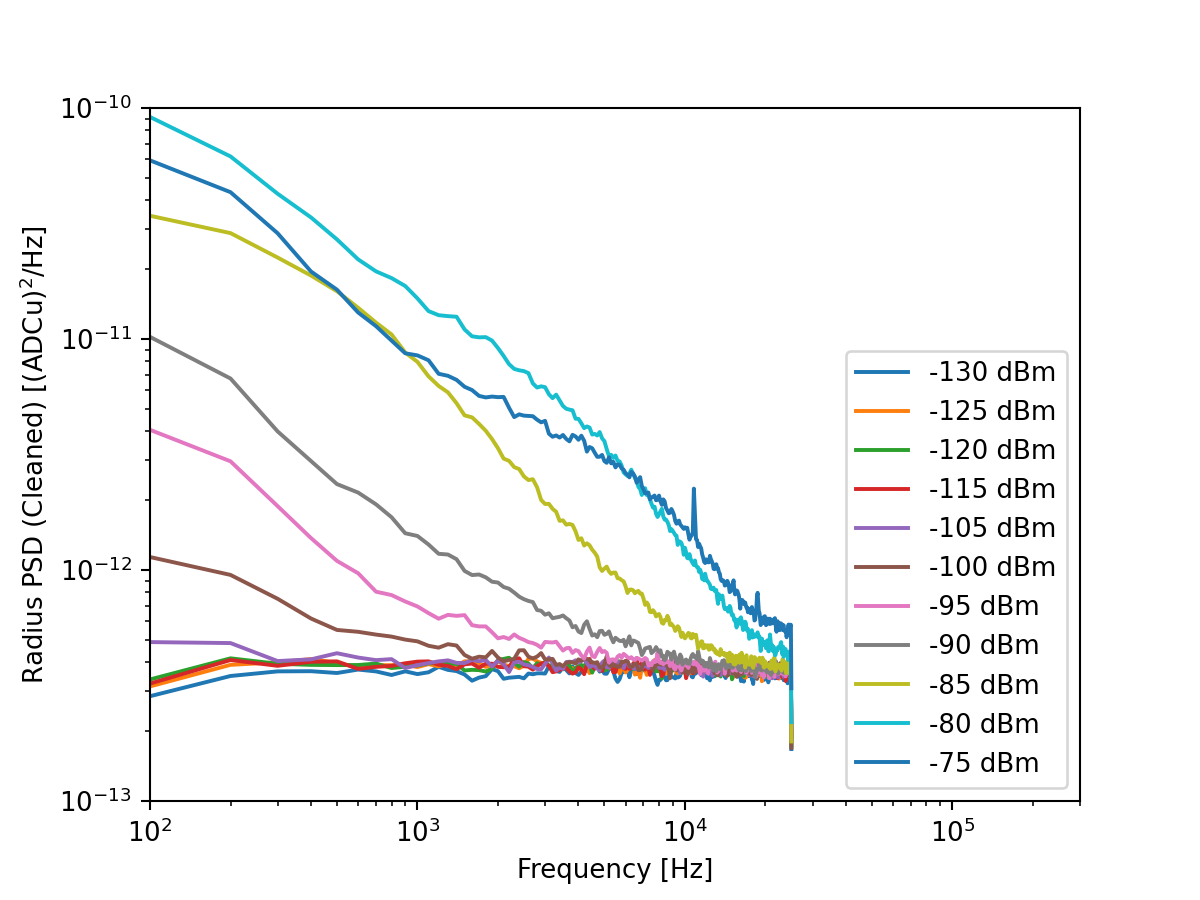

<IPython.core.display.Javascript object>


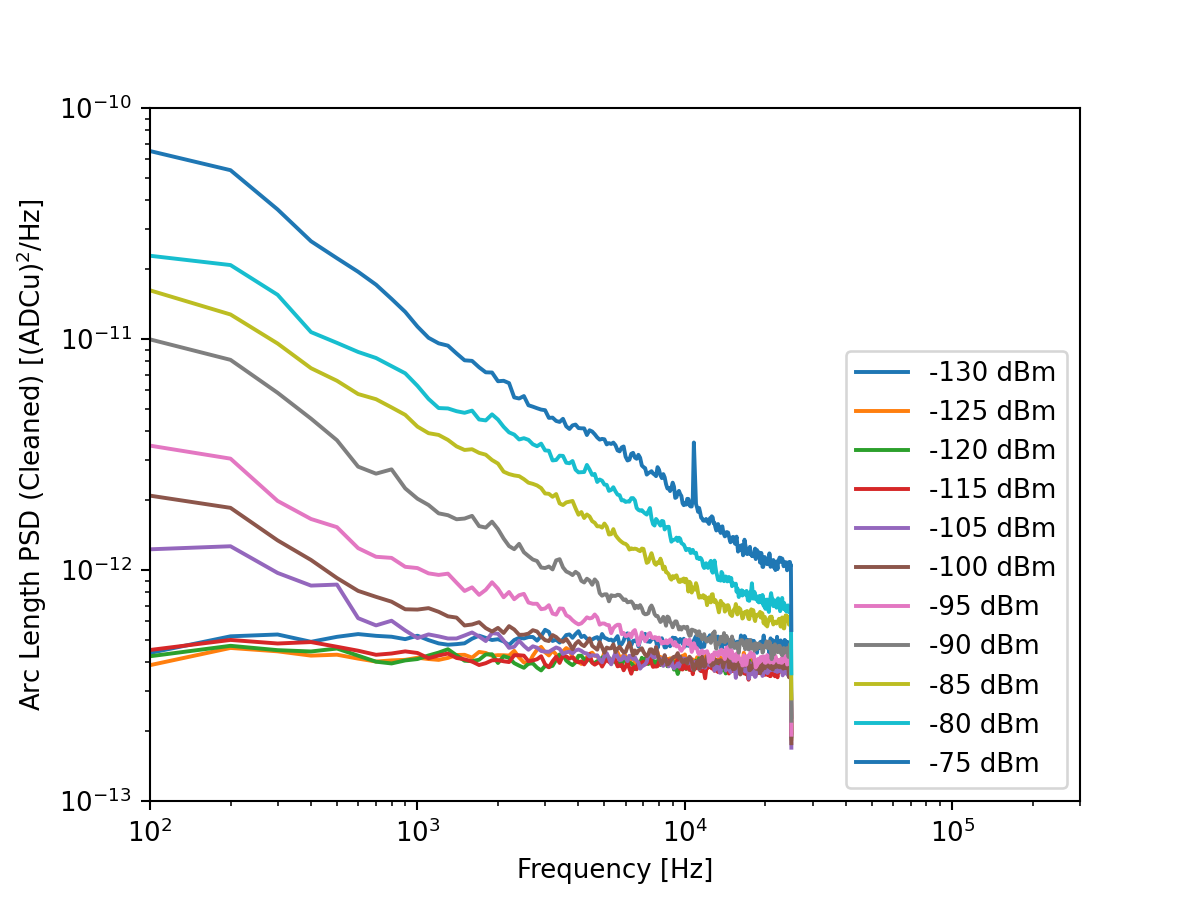

<IPython.core.display.Javascript object>


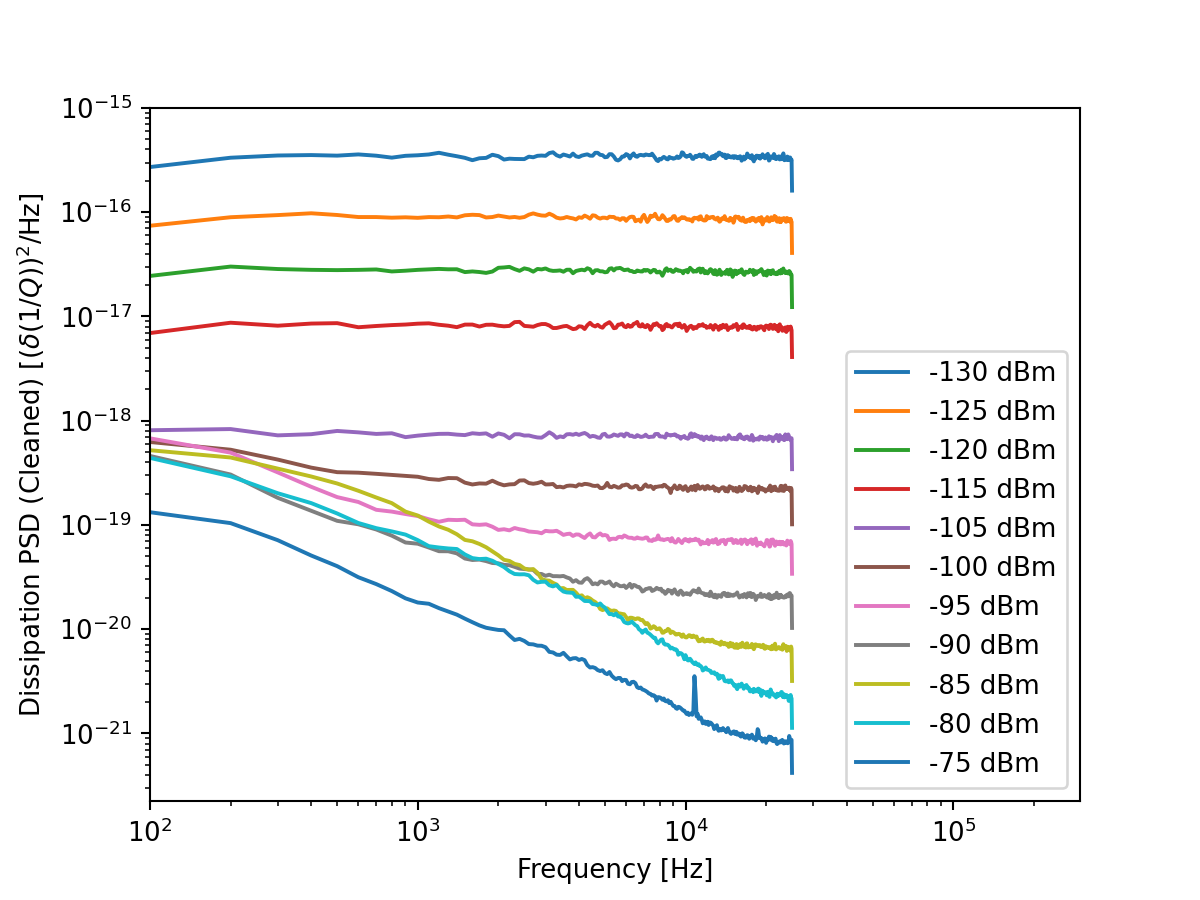

<IPython.core.display.Javascript object>


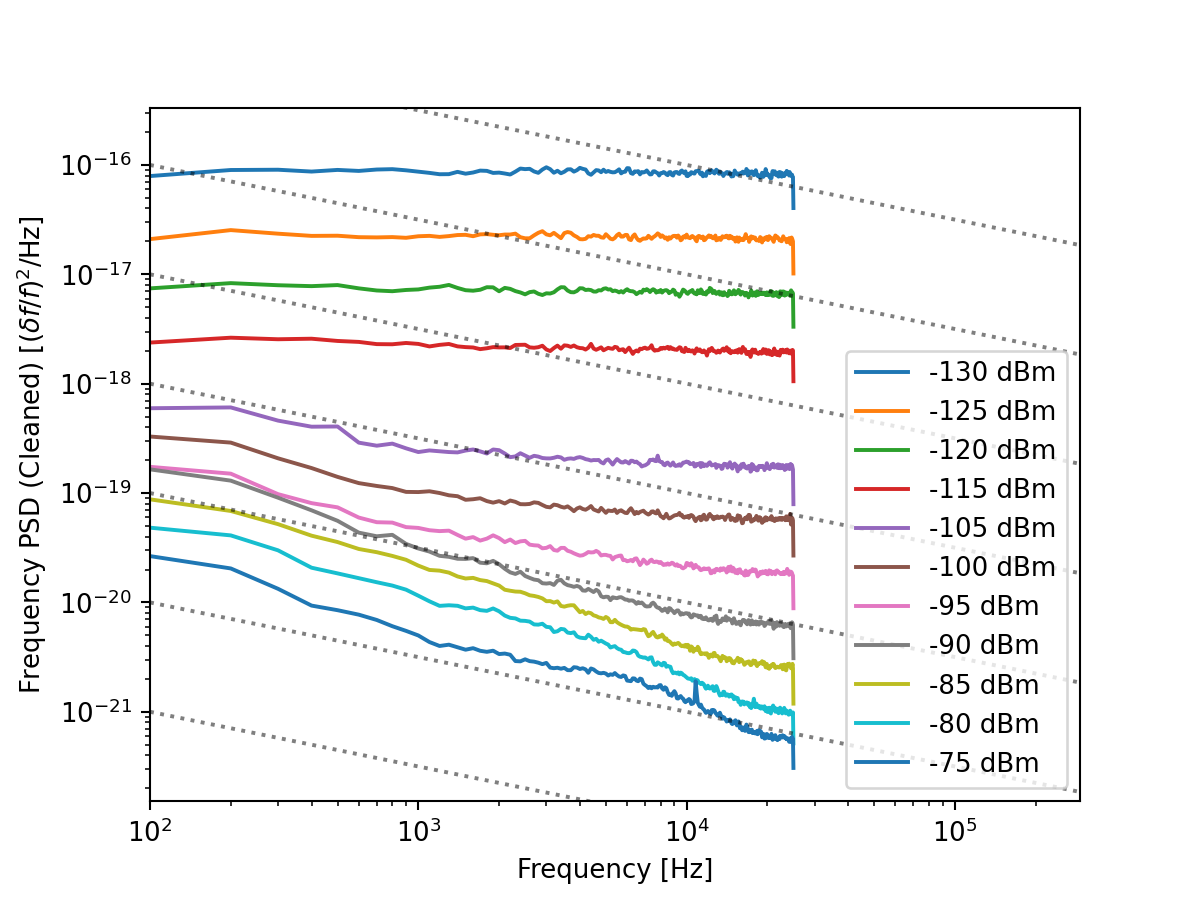

<IPython.core.display.Javascript object>


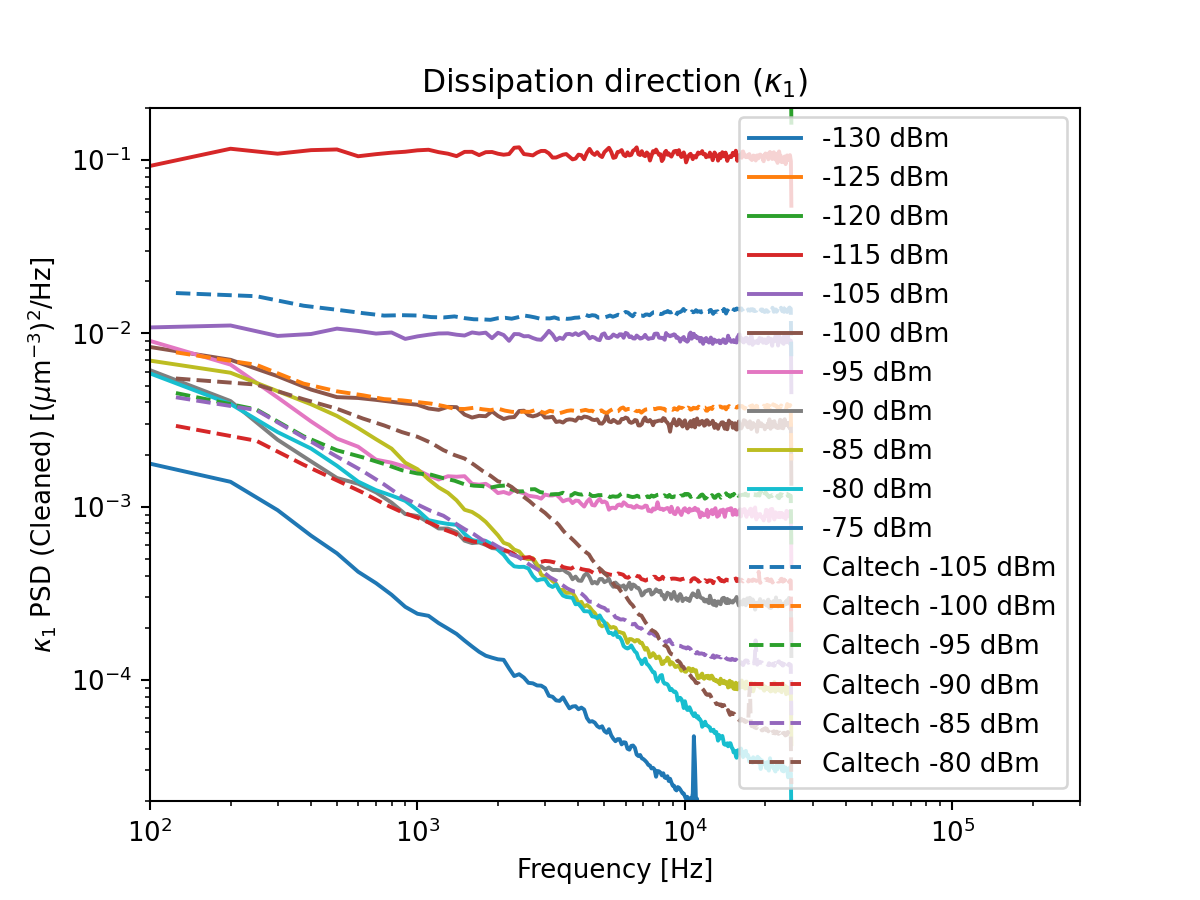

<IPython.core.display.Javascript object>


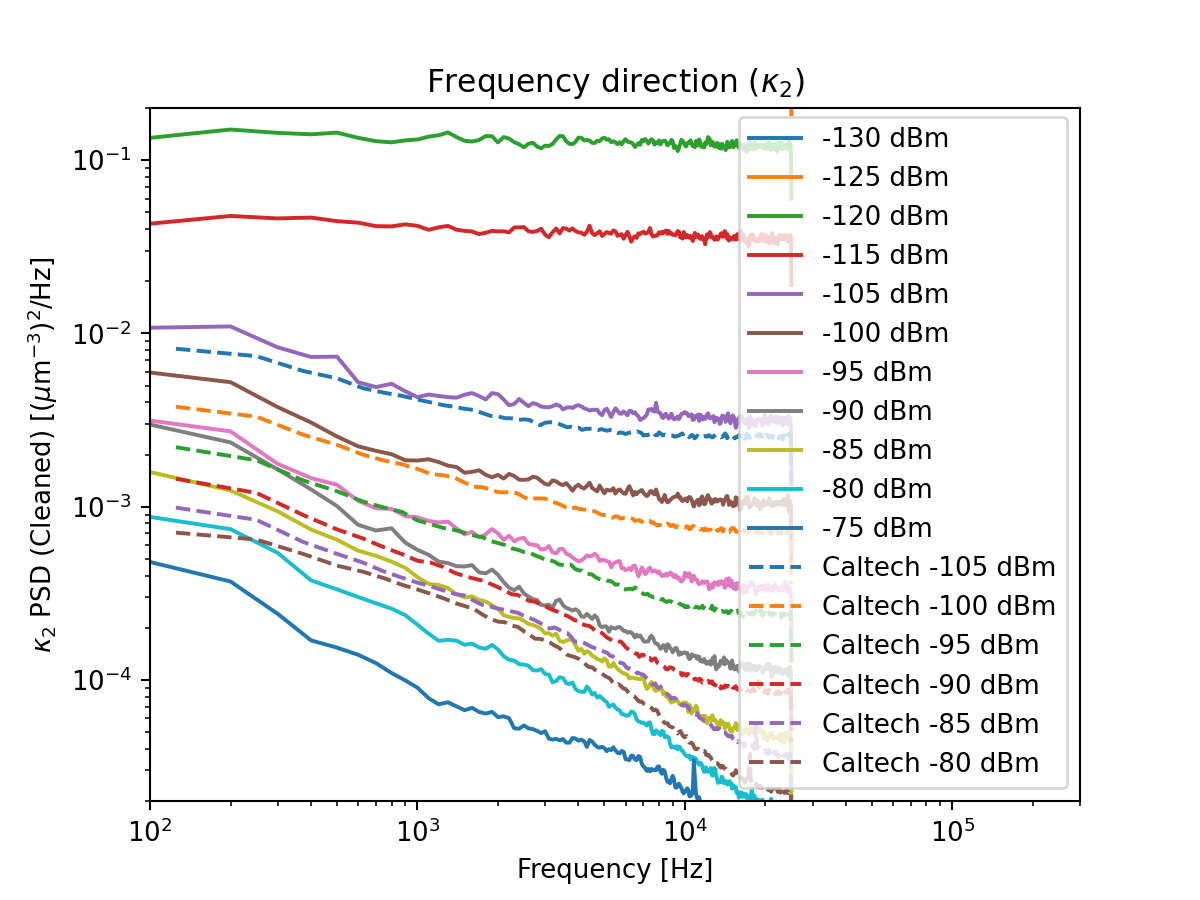

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_092104/USRP_Noise_20221108_092104_delta0.h5 because override=True!
found 11 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_092104/USRP_Noise_20221108_092104_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_092238/USRP_Noise_20221108_092238_delta0.h5 because override=True!
found 11 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_092238/USRP_Noise_20221108_092238_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_092406/USRP_Noise_20221108_092406_delta0.h5 because override=True!
found 8 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_092406/USRP_Noise_20221108_092406_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_092534/USRP_Noise_20221108_092534_delta0.h5 because override=True!
found 3 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_092534/USRP_Noise_20221108_092534_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_092834/USRP_Noise_20221108_092834_delta0.h5 because override=True!
found 2 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_092834/USRP_Noise_20221108_092834_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_093003/USRP_Noise_20221108_093003_delta0.h5 because override=True!
found 6 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_093003/USRP_Noise_20221108_093003_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_093132/USRP_Noise_20221108_093132_delta0.h5 because override=True!
found 5 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_093132/USRP_Noise_20221108_093132_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_093301/USRP_Noise_20221108_093301_delta0.h5 because override=True!
found 6 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_093301/USRP_Noise_20221108_093301_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_093431/USRP_Noise_20221108_093431_delta0.h5 because override=True!
found 5 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_093431/USRP_Noise_20221108_093431_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_093600/USRP_Noise_20221108_093600_delta0.h5 because override=True!
found 1 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_093600/USRP_Noise_20221108_093600_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Noise_Scans/20221108/20221108_093729/USRP_Noise_20221108_093729_delta0.h5 because override=True!
found 0 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Noise_Scans/20221108/20221108_093729/USRP_Noise_20221108_093729_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
Converting to quasiparticle basis!


In [14]:
psd_interst = Thf.PlotPSDsByPower(series_list, pwr_on_chip, 
    fHz_range     = [1e2,3e5],
    e_b_PSDrange  = [1e-13,1e-10], 
    r_b_PSDrange  = [5e-24,1e-15],
    q_b_PSDrange  = [2e-5,2e-1],
#     q_b_PSDrange  = [7e-6,1e1],
    MB_fit_result = MB_fit_vals, # None, # 
    PSD_lo_f      = 1e2, 
    PSD_hi_f      = 5e4, 
    f_transient   = 0.2,
    f_data        = f_interst,
    verbose       = False,
    psd_to_file   = True,
    res_to_file   = True,
)

In [15]:
def tls_shape(f,S_fmin,fmin):
    fdep = 1./np.sqrt(f)
    A    = S_fmin * np.sqrt(fmin)
    return A*fdep

## Draw some TLS lines to guide the eye
ax0 = plt.figure(4).gca()

ylim = ax0.get_ylim()

A_vals    = np.logspace(start=-22,stop=-15,num=8)
fHz_range = np.linspace(start=1e2,stop=3e5,num=100)
for A in A_vals:
    ax0.plot(fHz_range,tls_shape(fHz_range,A,fHz_range[0]),'k:',alpha=0.5)

ax0.set_ylim(ylim)

(5e-24, 1e-15)

In [16]:
print(psd_interst)

{-130: array([[1.00000000e+03, 3.54339595e-13, 5.19418795e-13, 3.51948702e-16,
        8.69302329e-17, 4.70108739e+00, 1.57174965e+00]]), -125: array([[1.00000000e+03, 3.80089881e-13, 4.17040364e-13, 8.83795572e-17,
        2.22934181e-17, 1.18051304e+00, 4.03078095e-01]]), -120: array([[1.00000000e+03, 3.86176344e-13, 4.11638973e-13, 2.80084670e-17,
        7.27839856e-18, 3.74117733e-01, 1.31597719e-01]]), -115: array([[1.00000000e+03, 4.01162297e-13, 4.37276476e-13, 8.53166472e-18,
        2.31048837e-18, 1.13960076e-01, 4.17749858e-02]]), -105: array([[1.00000000e+03, 3.87354260e-13, 5.07327084e-13, 7.19638186e-19,
        2.37129922e-19, 9.61242786e-03, 4.28744782e-03]]), -100: array([[1.00000000e+03, 4.91034167e-13, 6.74041657e-13, 2.90037668e-19,
        1.02114163e-19, 3.87412212e-03, 1.84628387e-03]]), -95: array([[1.00000000e+03, 6.95280117e-13, 1.01942857e-12, 1.21832151e-19,
        4.79990845e-20, 1.62734938e-03, 8.67851545e-04]]), -90: array([[1.00000000e+03, 1.40397523e-

## Read in the Caltech PSD data

In [17]:
# path  = "/data/Misc"
# f_pfx = "LTD19 "
# f_sfx = " noise qp.csv"

# k1_data = np.loadtxt(os.path.join(path,f_pfx+"k1"+f_sfx), delimiter=",", skiprows=1)
# k2_data = np.loadtxt(os.path.join(path,f_pfx+"k2"+f_sfx), delimiter=",", skiprows=1)

# caltech_powers = np.array([-80])
# caltech_powers = np.arange(start=-110, stop=-75, step=5)
# print(caltech_powers)

In [18]:
path  = "/data/Misc"
f_pfx = "LTD19 "
f_sfx = " noise qp.csv"

k1_data = pd.read_csv(os.path.join(path,f_pfx+"k1"+f_sfx), sep=",", header=0, index_col=False)
k2_data = pd.read_csv(os.path.join(path,f_pfx+"k2"+f_sfx), sep=",", header=0, index_col=False)

line_atten_dB_caltech = 70

In [19]:
caltech_powers = np.array(k1_data.keys())[1:].astype(int)
caltech_powers = caltech_powers - line_atten_dB_caltech
print(caltech_powers)

[-110 -105 -100  -95  -90  -85  -80]


In [20]:
## Count how many columns of PSDs there are
n_psd_cols = len(caltech_powers)

## Loop over every PSD (by power)
# for i in np.arange(n_psd_cols)+1:
for i in np.arange(n_psd_cols-1)+2:
    ## Pull the right column
    this_k1_data = k1_data[k1_data.keys()[i]]
    this_k2_data = k2_data[k2_data.keys()[i]]
    
    ## Pick the color
#     c = "C" + str(i-1)
    c = "C" + str(i-2)
    
    ## Add the k1 data to the right plot
    ax1 = plt.figure(5).gca()
    ax1.plot(k1_data['freq'],this_k1_data,color=c,ls='--',label="Caltech "+str(caltech_powers[i-1])+" dBm")
    
    ## Add the k2 data to the right plot
    ax2 = plt.figure(6).gca()
    ax2.plot(k2_data['freq'],this_k2_data,color=c,ls='--',label="Caltech "+str(caltech_powers[i-1])+" dBm")
    
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

## Check the readout frequencies for each power

In [21]:
for i in np.arange(len(series_list)):
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series_list[i], verbose=False)
    metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
    print(series_list[i],"(",pwr_on_chip[i],"dBm) f_r:", avg_frqs[0], "MHz")

20221108_092104 ( -130 dBm) f_r: 4242.0480179999995 MHz
20221108_092238 ( -125 dBm) f_r: 4242.04818 MHz
20221108_092406 ( -120 dBm) f_r: 4242.04804 MHz
20221108_092534 ( -115 dBm) f_r: 4242.048011 MHz
20221108_092834 ( -105 dBm) f_r: 4242.047471 MHz
20221108_093003 ( -100 dBm) f_r: 4242.047559 MHz
20221108_093132 ( -95 dBm) f_r: 4242.0474349999995 MHz
20221108_093301 ( -90 dBm) f_r: 4242.047036999999 MHz
20221108_093431 ( -85 dBm) f_r: 4242.046378999999 MHz
20221108_093600 ( -80 dBm) f_r: 4242.044304999999 MHz
20221108_093729 ( -75 dBm) f_r: 4242.038302 MHz


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


## Investigate TLS contribution

In [22]:
def dBm_to_mW(dBm):
    return 1.0 * np.power(10,dBm/10)

In [23]:
df_f_PSD_pts = np.zeros(len(pwr_on_chip))

for i in np.arange(len(pwr_on_chip)):
    d = psd_interst[pwr_on_chip[i]][0]
    df_f_PSD_pts[i] = d[4]
    print(pwr_on_chip[i],d[0],d[4],dBm_to_mW(pwr_on_chip[i]))

-130 1000.0 8.69302328565701e-17 1e-13
-125 1000.0 2.2293418122687006e-17 3.162277660168379e-13
-120 1000.0 7.278398564522888e-18 1e-12
-115 1000.0 2.310488366676152e-18 3.1622776601683794e-12
-105 1000.0 2.3712992225986054e-19 3.1622776601683794e-11
-100 1000.0 1.0211416264230633e-19 1e-10
-95 1000.0 4.799908452479194e-20 3.1622776601683795e-10
-90 1000.0 3.1137695686175265e-20 1e-09
-85 1000.0 2.170045956471819e-20 3.1622776601683795e-09
-80 1000.0 1.1520035053853294e-20 1e-08
-75 1000.0 4.987522424602791e-21 3.162277660168379e-08


<IPython.core.display.Javascript object>


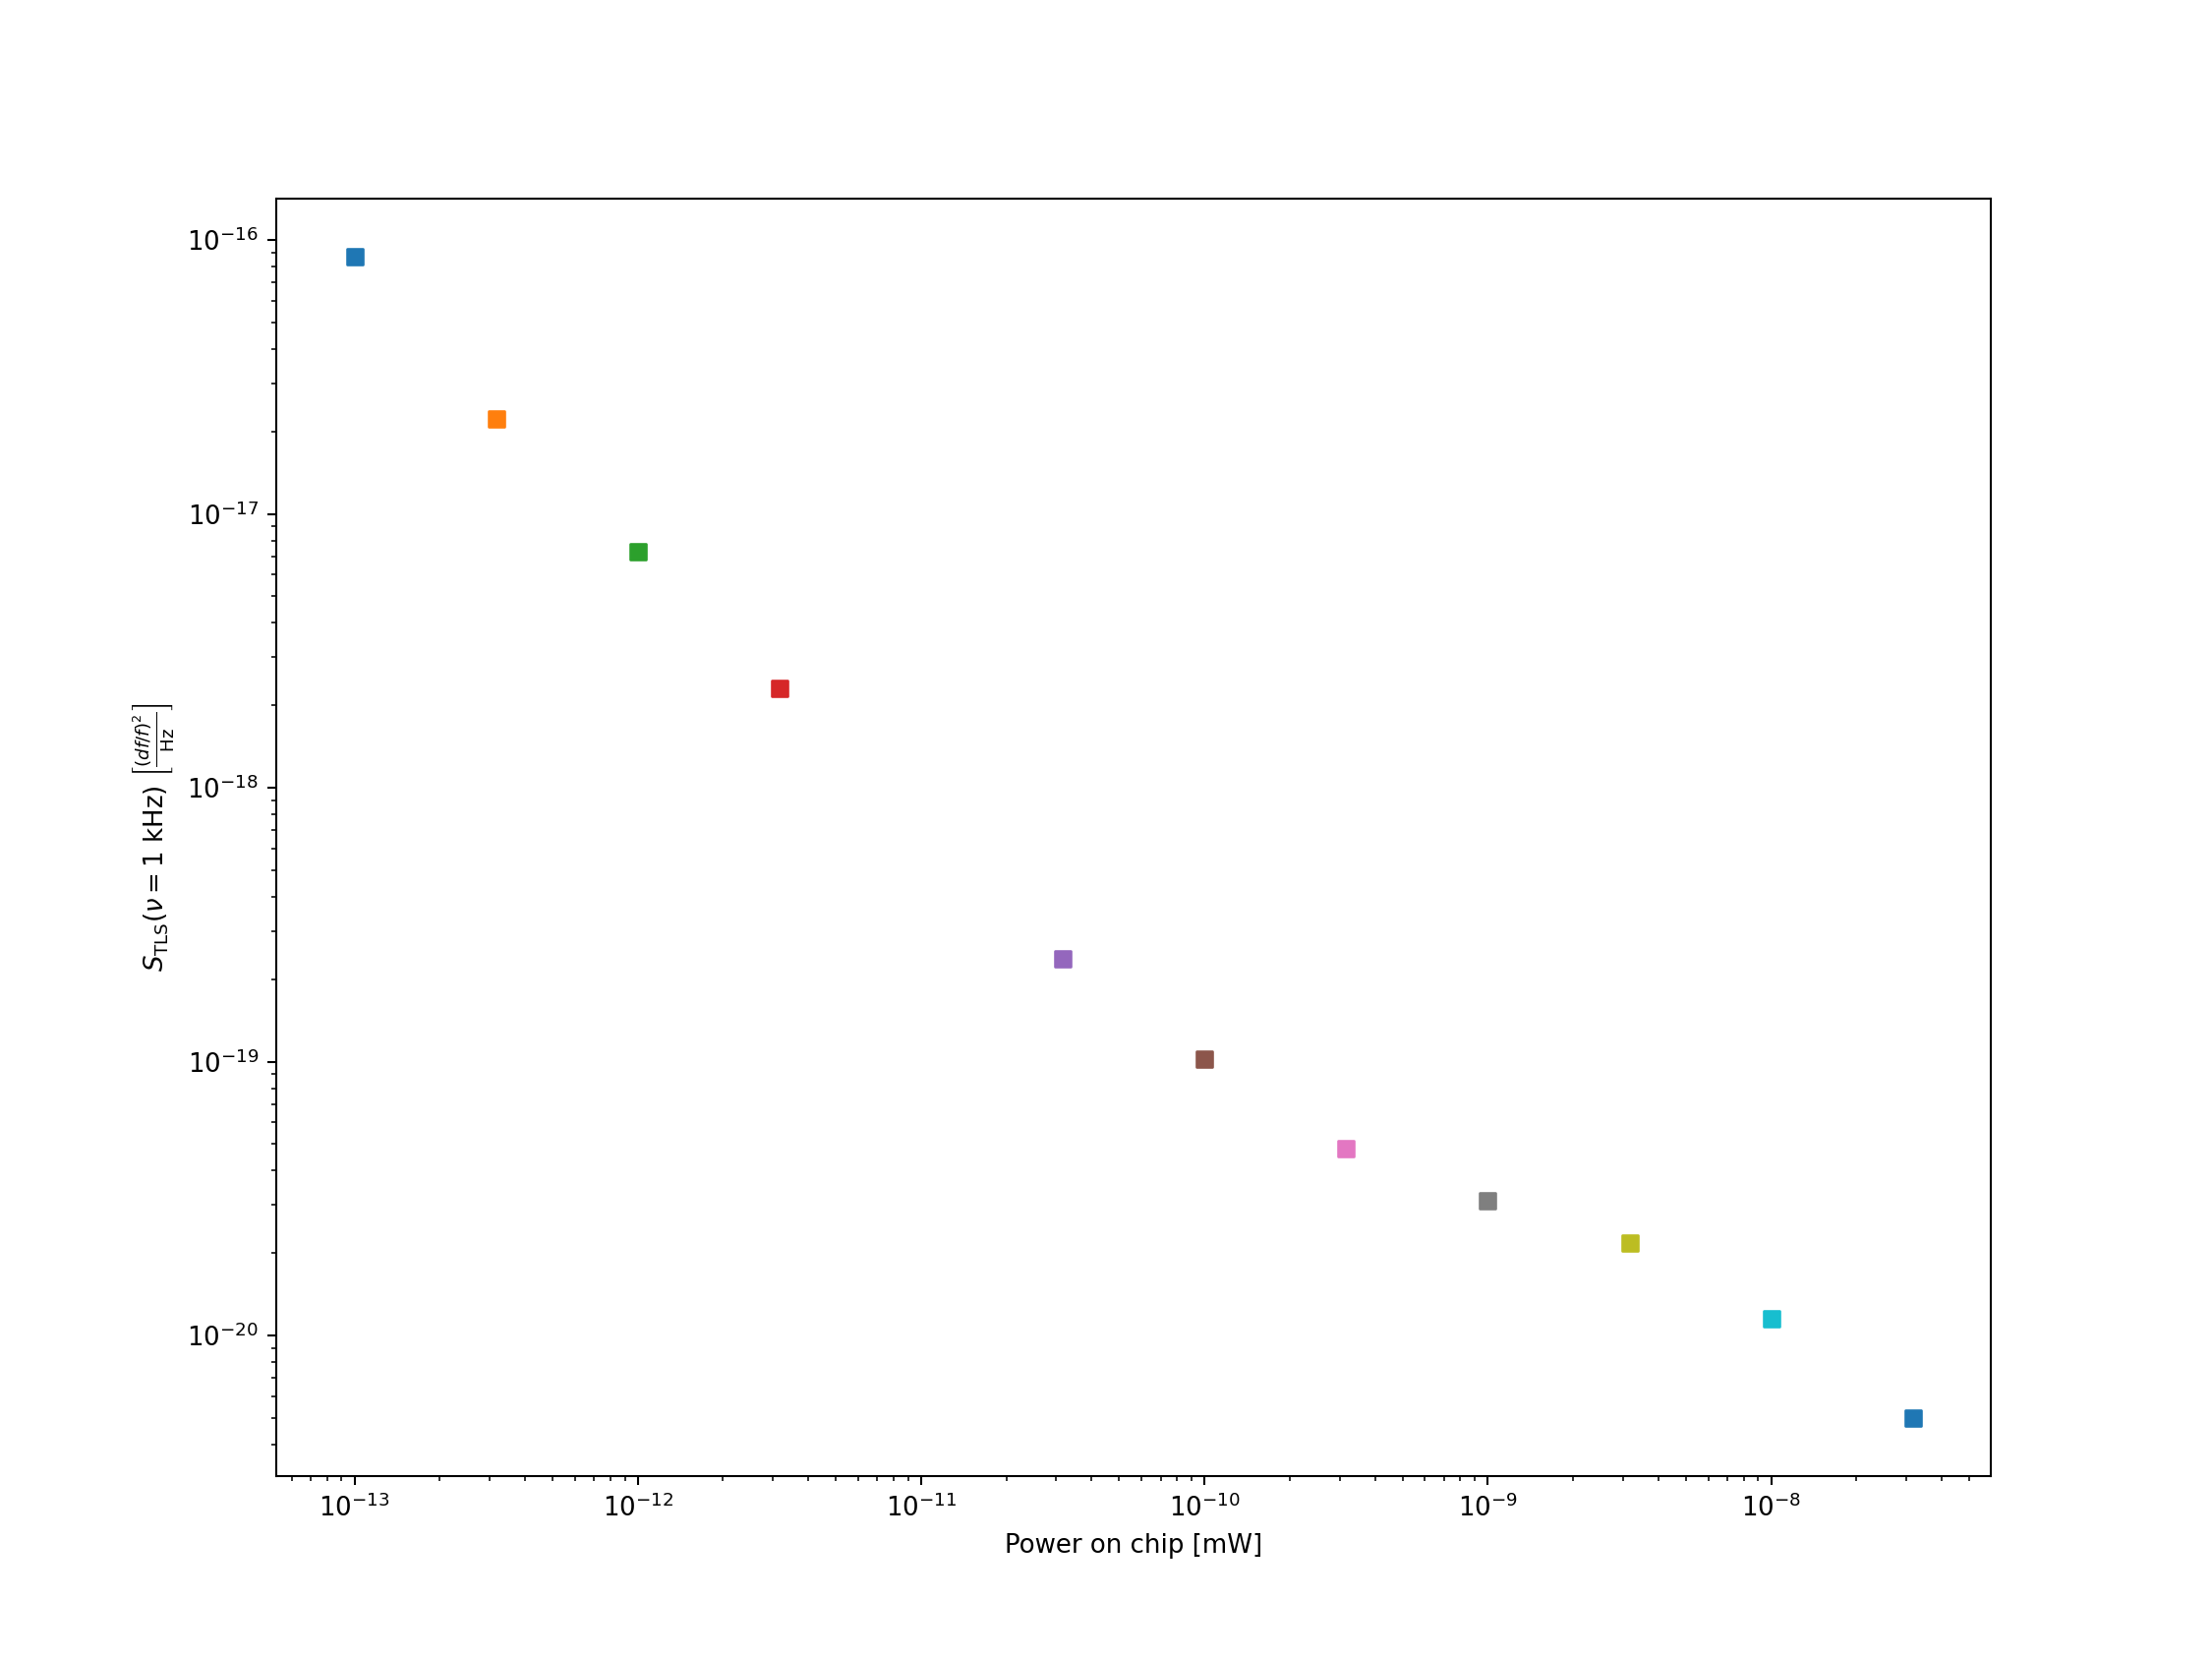

In [24]:
fig = plt.figure()
ax1 = fig.gca()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r"$S_\mathrm{TLS}(\nu=1$ kHz) $\left[ \frac{(df/f)^2}{\mathrm{Hz}} \right]$")
ax1.set_xlabel("Power on chip [mW]")

for i in np.arange(len(pwr_on_chip)):
    ax1.scatter(dBm_to_mW(pwr_on_chip[i]),df_f_PSD_pts[i],marker='s',color='C'+str(i))

<IPython.core.display.Javascript object>


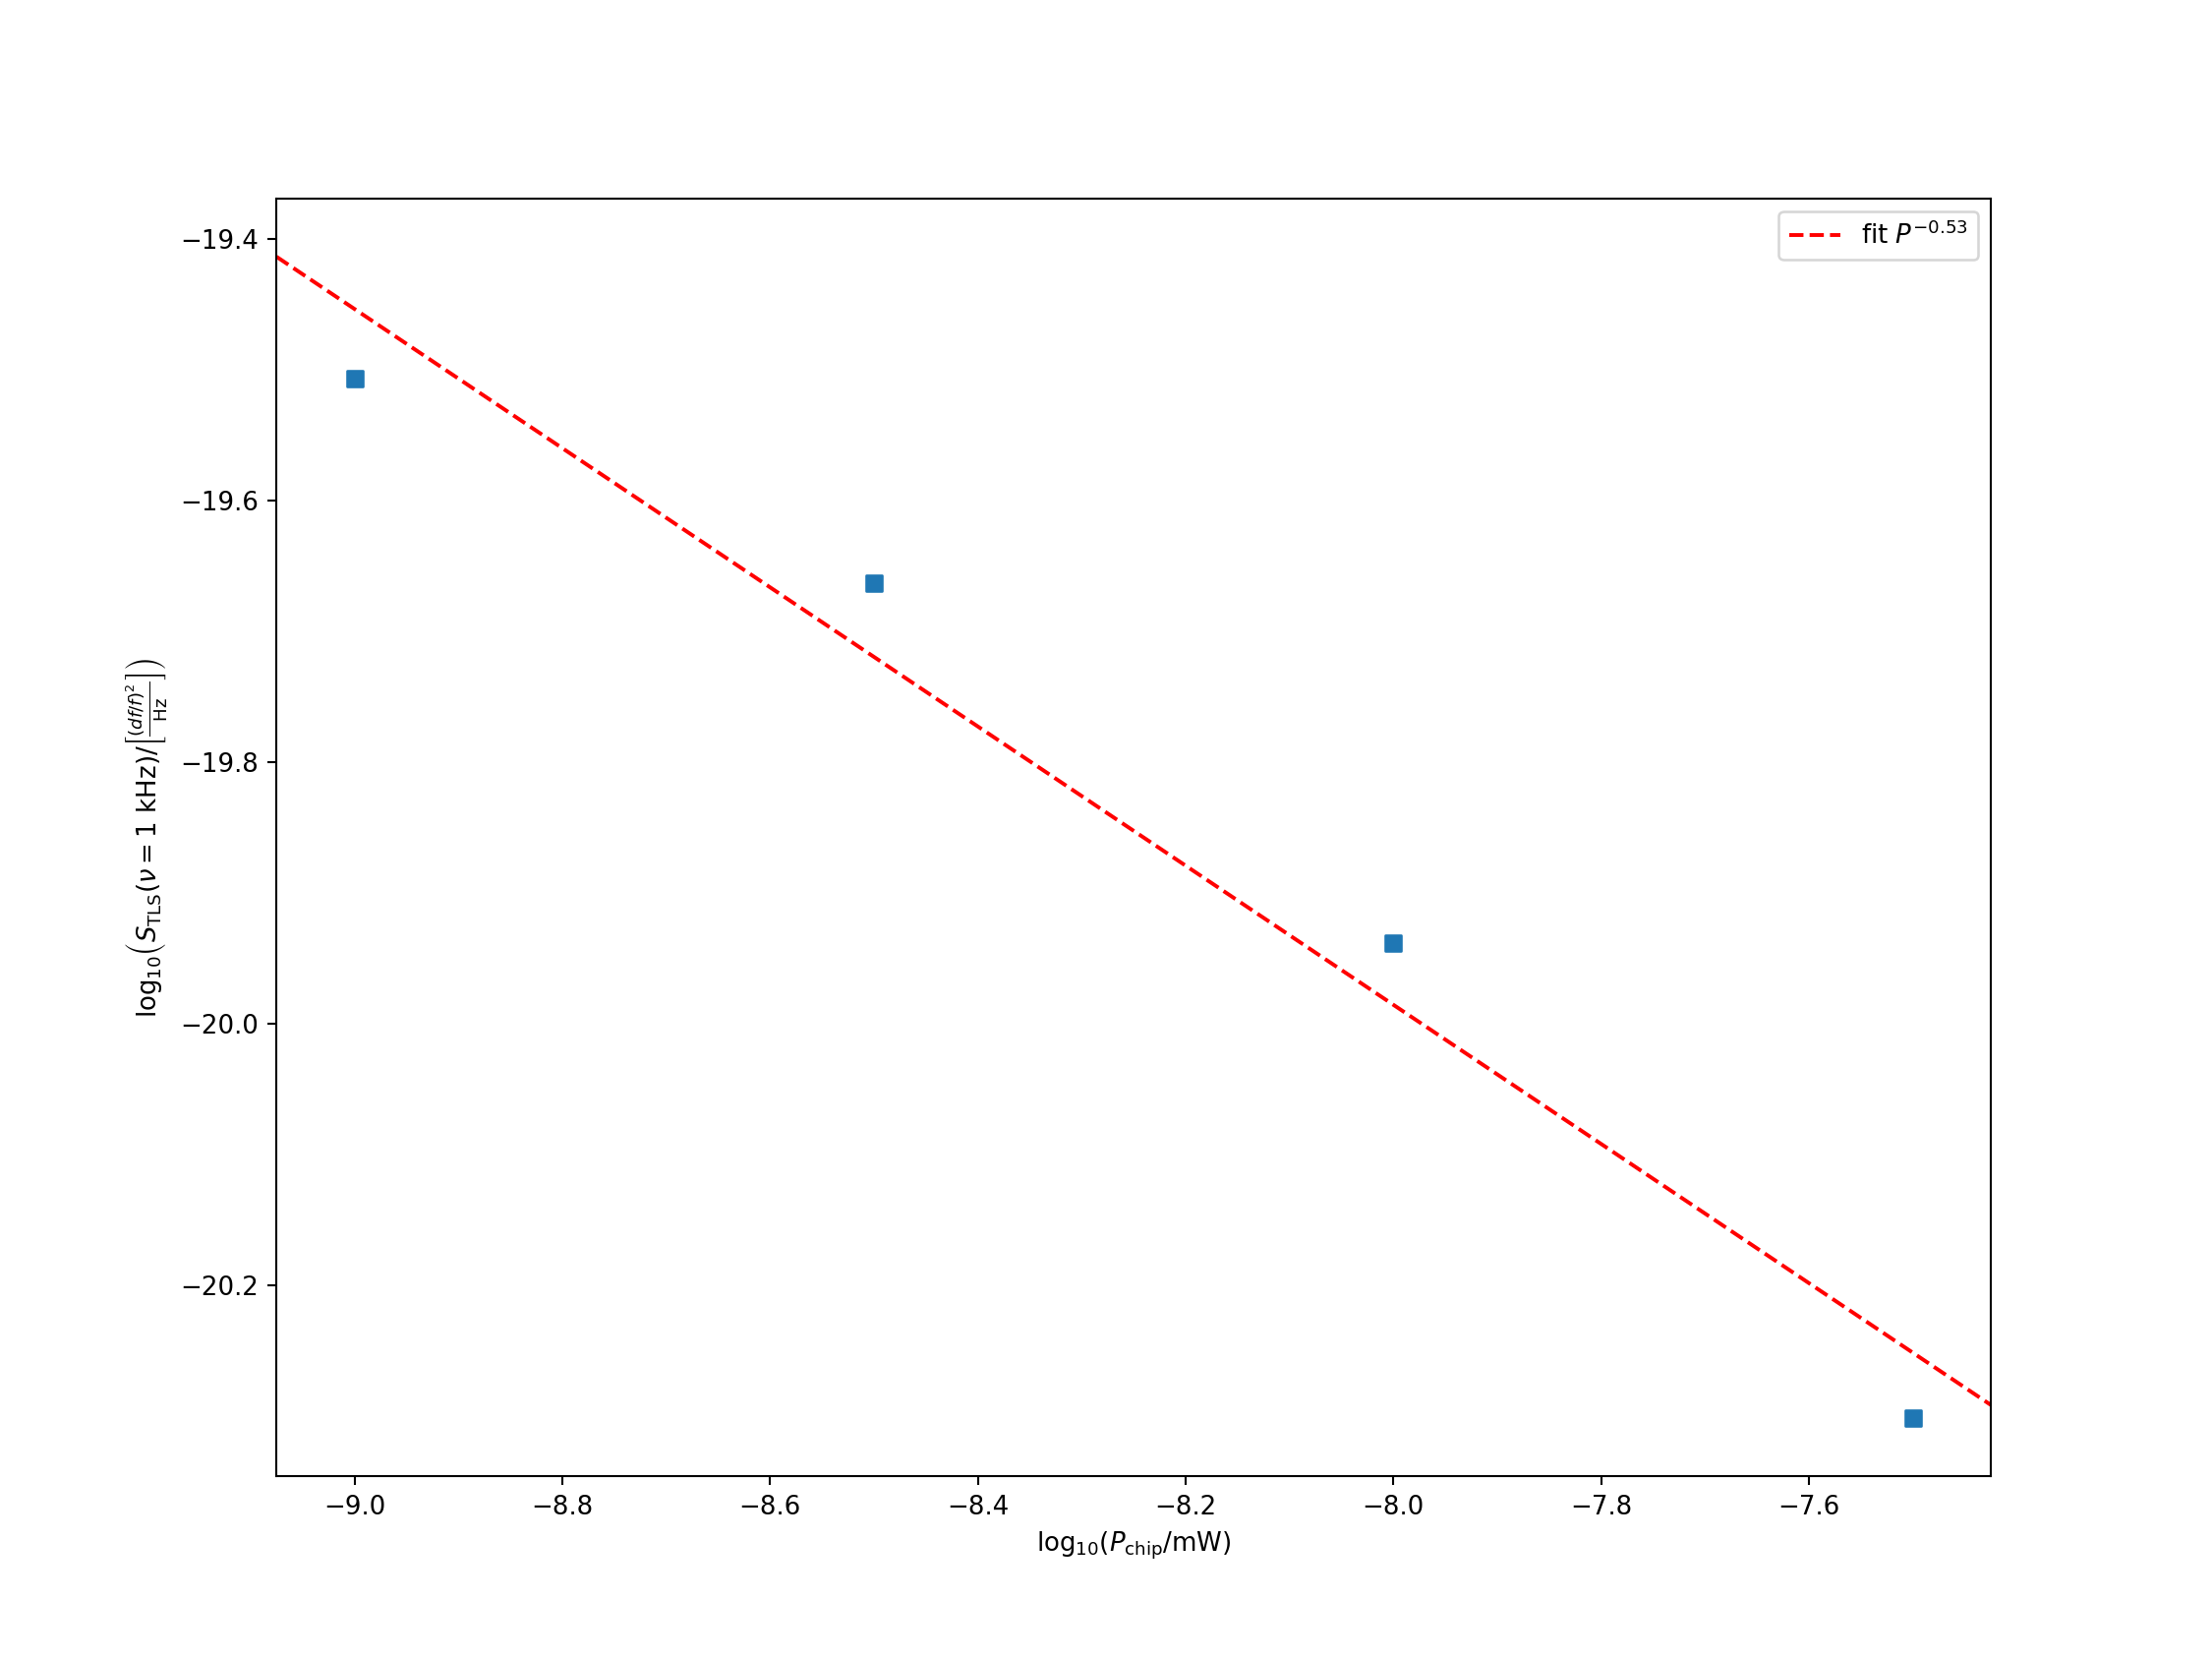

k= -0.5322439912673901
a= 5.705064881218098e-25


In [25]:
from scipy.optimize import curve_fit

def pow_law(x,A,n):
    return A * np.power(x,n)

line = lambda lx,la,k: la + k*lx

# lx_data = np.log10(dBm_to_mW(pwr_on_chip[pwr_on_chip != -106.5]))
# ly_data = np.log10(df_f_PSD_pts[pwr_on_chip != -106.5])

lx_data = np.log10(dBm_to_mW(pwr_on_chip))[-4:]
ly_data = np.log10(df_f_PSD_pts)[-4:]

popt, pcov = curve_fit(line,lx_data,ly_data,p0=[-25,-0.5])

ax1 = plt.figure().gca()
ax1.set_xlabel(r"$\log_{10}(P_\mathrm{chip}/\mathrm{mW})$")
ax1.set_ylabel(r"$\log_{10}\left(S_\mathrm{TLS}(\nu=1 ~\mathrm{kHz}) / \left[ \frac{(df/f)^2}{\mathrm{Hz}} \right] \right)$")
ax1.scatter(lx_data,ly_data,marker='s',color='C0')

xlims = ax1.get_xlim()
xvals = np.linspace(start=xlims[0],stop=xlims[1],num=5)
yvals = line(xvals,popt[0],popt[1])
ax1.plot(xvals,yvals,'r--',label=r"fit $P^{"+str(int(100.0*popt[1])/100.0)+"}$")
ax1.legend()
ax1.set_xlim(xlims)

print("k=", popt[1])
print("a=", 10**popt[0])

<IPython.core.display.Javascript object>


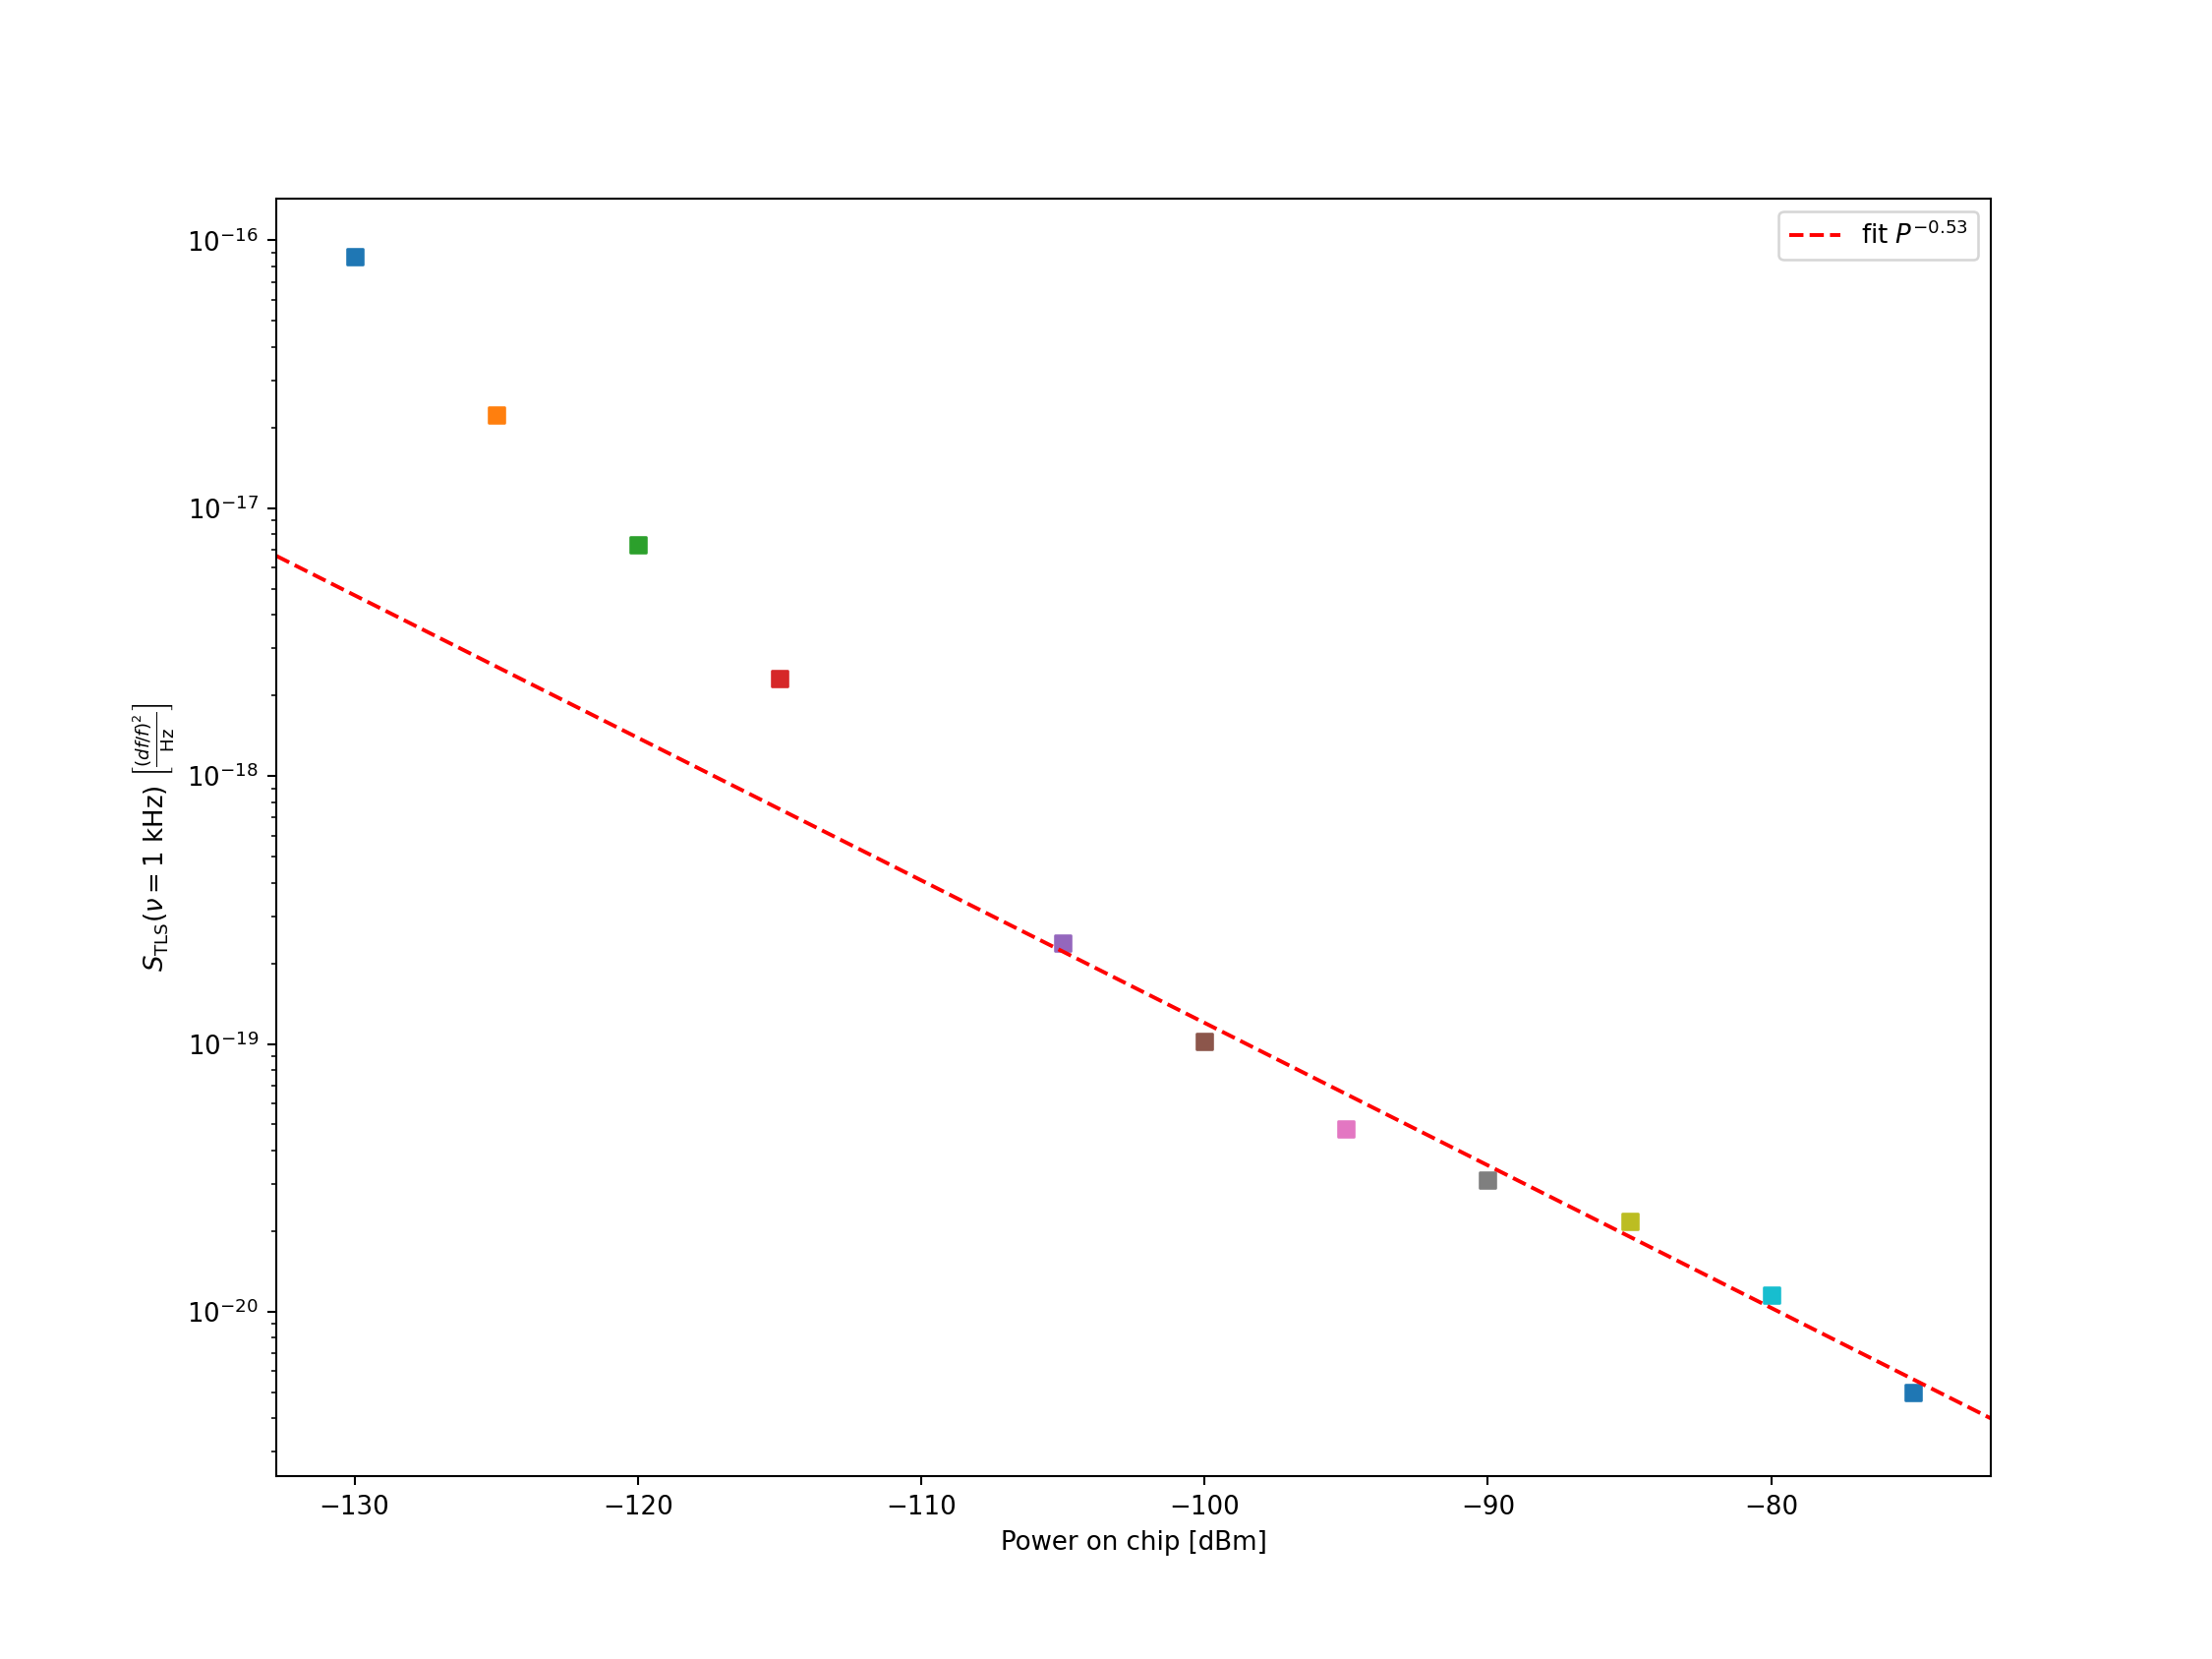

In [26]:
fig = plt.figure()
ax1 = fig.gca()
ax1.set_yscale('log')
ax1.set_ylabel(r"$S_\mathrm{TLS}(\nu=1$ kHz) $\left[ \frac{(df/f)^2}{\mathrm{Hz}} \right]$")
ax1.set_xlabel("Power on chip [dBm]")

for i in np.arange(len(pwr_on_chip)):
    ax1.scatter(pwr_on_chip[i],df_f_PSD_pts[i],marker='s',color='C'+str(i))
    
xlims = ax1.get_xlim()
xvals = np.linspace(start=xlims[0],stop=xlims[1],num=10)
yvals = pow_law(dBm_to_mW(xvals),10**popt[0],popt[1])
ax1.plot(xvals,yvals,'r--',label=r"fit $P^{"+str(int(100*popt[1])/100.)+"}$")

# ax1.plot(xvals,pow_law(dBm_to_mW(xvals),3.0e-24,-0.47),'r:',alpha=0.5,label=r"Guess $P^{-0.47}$")
# ax1.plot(xvals,pow_law(dBm_to_mW(xvals),0.8e-23,-0.43),'b:',alpha=0.5,label=r"Guess $P^{-0.43}$")
# ax1.plot(xvals,pow_law(dBm_to_mW(xvals),5.5e-25,-0.55),'g:' ,alpha=0.5,label=r"$P^{-0.55}$")

ax1.set_xlim(xlims)
ax1.legend()